In [1]:
import mne
import numpy as np
from pymatreader import read_mat
import matplotlib.pyplot as plt

In [2]:
%matplotlib qt

In [3]:
data = read_mat("/Users/ardkastrati/Documents/test-preprocessing/AA8_WI1_EEG.mat") # AA0_WI2_EEG.mat")
matlab_filtered_zaplined_interpolated = read_mat("/Users/ardkastrati/Documents/test-preprocessing/gip_AA8_WI1_EEG.mat")

/Users/ardkastrati/opt/anaconda3/envs/test-prep/lib/python3.8/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


In [13]:
data["sEEG"]

{'setname': 'EGI file',
 'filename': array([], dtype='<U1'),
 'filepath': array([], dtype='<U1'),
 'subject': array([], dtype='<U1'),
 'group': array([], dtype='<U1'),
 'condition': array([], dtype='<U1'),
 'session': array([], dtype=uint8),
 'comments': 'Original file: /home/stimuluspc/Neurometric/All_Subjects/AA8/AA8 20190614 1312003.RAW',
 'nbchan': 132,
 'trials': 1,
 'pnts': 69545,
 'srate': 500,
 'xmin': 0,
 'xmax': 139.088,
 'times': array([     0,      2,      4, ..., 139084, 139086, 139088], dtype=int32),
 'data': array([[-30323.03 , -30326.262, -30329.027, ..., -29016.582, -29011.062,
         -29003.57 ],
        [-25967.385, -25964.06 , -25969.018, ..., -25530.184, -25525.88 ,
         -25523.04 ],
        [-29970.701, -29953.973, -29953.508, ..., -28820.684, -28809.271,
         -28805.645],
        ...,
        [     0.   ,      0.   ,      0.   , ...,      0.   ,      0.   ,
              0.   ],
        [     0.   ,      0.   ,      0.   , ...,      0.   ,      0.   ,
 

In [4]:
def create_raw(data):
    # Now we deal with MNE to get the right data structure ...
    # Create some dummy metadata
    if "EEG" in data:
        data_key = "EEG"
    else:
        data_key = "sEEG"
    ch_names = data[data_key]["urchanlocs"]["labels"]
    ch_types = ["eeg" for _ in range(len(ch_names))]
    sampling_freq = data[data_key]["srate"]  # in Hertz
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    
    times = data[data_key]["times"]
    eeg_data = np.array(data[data_key]['data'][:128], dtype='float') / 1000000 # in Volt
    raw = mne.io.RawArray(eeg_data, info)
    return raw

In [14]:
from pyprep.prep_pipeline import PrepPipeline

def Union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list
    
def find_bad_by_prep(raw, matlab_strict=True, hacky=False):
    # Add a montage to the data
    montage_kind = "GSN-HydroCel-128"
    montage = mne.channels.make_standard_montage(montage_kind)
    
    prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": np.arange(50, raw.info['sfreq'] / 2, 50),
    }
    
    prep = PrepPipeline(raw.copy(), prep_params, montage, matlab_strict=matlab_strict)
    prep.fit()
    
    # print("Bad channels: {}".format(prep.interpolated_channels))
    # print("Bad channels after interpolation: {}".format(prep.still_noisy_channels))
    print("BAD CHANNELS: ", Union(prep.interpolated_channels, prep.still_noisy_channels))
    raw.set_montage(montage)
    raw.info["bads"].extend(Union(prep.interpolated_channels, prep.still_noisy_channels))
    if hacky:
        raw.info["bads"] = ["E" + str(i) for i in [1, 2, 8, 25, 26, 32, 33, 38, 44, 45, 56, 57, 73, 99, 100, 101, 108, 125, 128]]    

    return raw

In [15]:
from pyprep.utils import _eeglab_create_highpass, _eeglab_fir_filter

def filter(raw, matlab_strict=True):
    EEG = raw.get_data(picks="eeg")
    picks = mne.pick_types(raw.info, eeg=True)
    if matlab_strict:
        filt = _eeglab_create_highpass(0.1, raw.info['sfreq'])
        EEG[picks, :] = _eeglab_fir_filter(EEG[picks, :], filt)
    else:
        EEG = mne.filter.filter_data(
            EEG,
            sfreq=raw.info['sfreq'],
            l_freq=0.1,
            h_freq=None,
            picks=picks,
        )
    filtered_raw = mne.io.RawArray(EEG, raw.info)
    return filtered_raw

In [16]:
from meegkit import dss

def zapline_clean(raw, fline=50):
    EEG = raw.get_data(picks="eeg") # Convert mne data to numpy darray
    picks = mne.pick_types(raw.info, eeg=True)
    sfreq = raw.info['sfreq'] # Extract the sampling freq
       
    #Apply MEEGkit toolbox function
    out , _ = dss.dss_line(EEG[picks, :].T, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    EEG[picks, :] = out.T
    cleaned_raw = mne.io.RawArray(EEG, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [17]:
from pyprep.utils import _eeglab_interpolate_bads

def interpolate(raw, matlab_strict=True):
    if matlab_strict:
        _eeglab_interpolate_bads(raw)
    else:
        raw.interpolate_bads()
    return raw

In [26]:
# run_minimal_preprocessing(data):
raw = create_raw(data)
bad_raw = find_bad_by_prep(raw.copy(), matlab_strict=True, hacky=True)
bad_filtered_raw = filter(bad_raw.copy(), matlab_strict=False)
bad_filtered_zaplined_raw = zapline_clean(bad_filtered_raw.copy())
bad_filtered_zaplined_interpolated_raw =interpolate(bad_filtered_zaplined_raw.copy(), matlab_strict=False)

Creating RawArray with float64 data, n_channels=128, n_times=69545
    Range : 0 ... 69544 =      0.000 ...   139.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


ARD:  [ 50. 100. 150. 200.]
ARD:  None
Removed notch frequencies (Hz):
     50.00 : 3328 windows
    100.00 : 3328 windows
    150.00 : 3328 windows
    200.00 : 3328 windows
ARD:  {'ref_chs': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E83', 'E84', 'E85', 'E86', 'E87', 'E88', 'E89', 'E90', 'E91', 'E92', 'E93', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E110', 'E111', 'E112', 'E113', 'E114', 'E

  0%|          |  : 0/27 [00:00<?,       ?it/s]


RANSAC done!


2024-04-18 14:18:02,123 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['E1', 'E8', 'E32', 'E128'], 'bad_by_hf_noise': ['E81'], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['E99'], 'bad_all': ['E8', 'E1', 'E99', 'E32', 'E128', 'E81']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/27 [00:00<?,       ?it/s]


RANSAC done!


2024-04-18 14:18:21,099 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['E8', 'E2', 'E1', 'E25', 'E32', 'E128'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['E57', 'E100', 'E99', 'E108', 'E56', 'E73'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['E101'], 'bad_all': ['E8', 'E2', 'E57', 'E1', 'E25', 'E100', 'E101', 'E99', 'E32', 'E108', 'E128', 'E56', 'E73']}
2024-04-18 14:18:21,749 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/27 [00:00<?,       ?it/s]


RANSAC done!


2024-04-18 14:18:39,219 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['E8', 'E2', 'E1', 'E25', 'E38', 'E32', 'E128'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['E57', 'E100', 'E101', 'E45', 'E99', 'E108', 'E56', 'E73'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['E101'], 'bad_all': ['E8', 'E2', 'E57', 'E1', 'E25', 'E100', 'E101', 'E38', 'E45', 'E99', 'E32', 'E108', 'E128', 'E56', 'E73']}
2024-04-18 14:18:39,686 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/27 [00:00<?,       ?it/s]


RANSAC done!


2024-04-18 14:18:55,686 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['E8', 'E2', 'E1', 'E25', 'E38', 'E32', 'E128'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['E57', 'E101', 'E100', 'E45', 'E99', 'E108', 'E107', 'E56', 'E73'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['E100', 'E101'], 'bad_all': ['E8', 'E73', 'E2', 'E57', 'E1', 'E25', 'E101', 'E100', 'E38', 'E45', 'E99', 'E32', 'E108', 'E128', 'E56', 'E107']}
2024-04-18 14:18:56,181 - pyprep.reference - INFO - Iterations: 3


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/27 [00:00<?,       ?it/s]


RANSAC done!


2024-04-18 14:19:12,619 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['E8', 'E2', 'E1', 'E25', 'E38', 'E32', 'E128'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['E73', 'E57', 'E100', 'E101', 'E45', 'E99', 'E108', 'E56', 'E107'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['E101', 'E100'], 'bad_all': ['E8', 'E2', 'E57', 'E1', 'E25', 'E100', 'E101', 'E38', 'E45', 'E99', 'E32', 'E108', 'E107', 'E128', 'E56', 'E73']}
2024-04-18 14:19:12,620 - pyprep.reference - INFO - Robust reference done


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/27 [00:00<?,       ?it/s]


RANSAC done!
Found 15 uniquely bad channels:

0 by NaN: []

0 by flat: []

7 by deviation: ['E1', 'E2', 'E8', 'E25', 'E32', 'E38', 'E128']

0 by HF noise: []

7 by correlation: ['E45', 'E56', 'E57', 'E73', 'E99', 'E107', 'E108']

0 by SNR: []

0 by dropout: []

1 by RANSAC: ['E100']

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/27 [00:00<?,       ?it/s]


RANSAC done!
BAD CHANNELS:  ['E8', 'E125', 'E2', 'E57', 'E1', 'E25', 'E100', 'E101', 'E38', 'E45', 'E99', 'E32', 'E33', 'E108', 'E107', 'E128', 'E56', 'E73']
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Creating RawArray with float64 data, n_channels=128, n_times=69545
    Range : 0 ... 69544 =      0.000 ...   139.088 secs
Ready.
[PCA] Explained variance of selected components : 31.85%
Power of components removed by DSS: 0.03
Creating RawArray with float64 data, n_channels=128, n_times=69545
    Range : 0 ... 69544 =      0.000 ...   139.088 secs
Ready.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 109 sensor positions
Interpolating 19 sensors


In [21]:
final_raw = bad_filtered_zaplined_interpolated_raw.copy().set_eeg_reference(ref_channels="average")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [24]:
sorted([int(a[1:]) for a in ['E8', 'E125', 'E2', 'E57', 'E1', 'E25', 'E100', 'E101', 'E38', 'E45', 'E99', 'E32', 'E33', 'E108', 'E107', 'E128', 'E56', 'E73']])

[1, 2, 8, 25, 32, 33, 38, 45, 56, 57, 73, 99, 100, 101, 107, 108, 125, 128]

In [25]:
# A nicer code for the plot
def plot_axis(i, axs, EEG_python, EEG_matlab, title, sampling_freq=500, clip=100):
    EEG_max = np.max(abs(EEG_python), axis=None)
    EEG_diff = EEG_python - EEG_matlab
    EEG_mse = (EEG_diff**2).mean(axis=None)

    # Clip for better plots
    EEG_python = np.clip(EEG_python, -clip, clip)
    EEG_matlab = np.clip(EEG_matlab, -clip, clip)
    EEG_diff = np.clip(EEG_diff, -clip, clip)
    im = axs[i, 0].imshow(
        EEG_python / 100,
        aspect="auto",
        extent=[0, (EEG_python.shape[1] / sampling_freq), 128, 0],
        vmin=-1,
        vmax=1,
        cmap=plt.get_cmap("RdBu"),
    )
    axs[i, 1].imshow(
        EEG_matlab / 100,
        aspect="auto",
        extent=[0, (EEG_matlab.shape[1] / sampling_freq), 128, 0],
        vmin=-1,
        vmax=1,
        cmap=plt.get_cmap("RdBu"),
    )
    axs[i, 2].imshow(
        EEG_diff / 100,
        aspect="auto",
        extent=[0, (EEG_diff.shape[1] / sampling_freq), 128, 0],
        vmin=-1,
        vmax=1,
        cmap=plt.get_cmap("RdBu"),
    )
    axs[i, 1].set_title(title, fontsize=14)
    if i == 0:
        cb = fig.colorbar(im, ax=axs, fraction=0.05, pad=0.04)
        cb.set_label("\u03BCVolt", fontsize=14)
    print(EEG_max, EEG_mse)

fig, axs = plt.subplots(5, 3, sharex="all", figsize=(16, 12))
plt.setp(fig, facecolor=[1, 1, 1])
fig.suptitle("Python versus Matlab PREP results", fontsize=16)
axs[0, 0].set_title("Python", fontsize=14)
axs[0, 1].set_title("Matlab", fontsize=14)
axs[0, 2].set_title("Difference", fontsize=14)
axs[4, 1].set_xlabel("Time(s)", fontsize=14)

EEG_dummy = 10000*np.ones(raw.copy().get_data(picks="eeg").shape)


EEG_raw = raw.copy().get_data(picks="eeg") * 1e6
EEG_matlab_raw = raw.copy().get_data(picks="eeg") * 1e6

EEG_filtered = bad_filtered_raw.copy().get_data(picks="eeg") * 1e6
EEG_filtered_matlab = EEG_dummy

EEG_cleaned = bad_filtered_zaplined_raw.copy().get_data(picks="eeg") * 1e6
EEG_cleaned_matlab = EEG_dummy

EEG_interpolated = bad_filtered_zaplined_interpolated_raw.copy().get_data(picks="eeg") * 1e6
EEG_interpolated_matlab = create_raw(matlab_filtered_zaplined_interpolated).copy().get_data(picks="eeg")[:, 9:] * 1e6

EEG_final = final_raw.copy().get_data(picks="eeg") * 1e6
EEG_final_matlab = EEG_dummy

plot_axis(0, axs, EEG_raw, EEG_matlab_raw, "Matlab")
plot_axis(1, axs, EEG_filtered, EEG_filtered_matlab, "High-Pass Filtered")
plot_axis(2, axs, EEG_cleaned, EEG_cleaned_matlab, "ZapLine Cleaned")
plot_axis(3, axs, EEG_interpolated, EEG_interpolated_matlab, "Interpolated")
plot_axis(4, axs, EEG_final, EEG_final_matlab, "Average Re-referenced")

Creating RawArray with float64 data, n_channels=128, n_times=69554
    Range : 0 ... 69553 =      0.000 ...   139.106 secs
Ready.
90155.9765625 0.0
35442.41796875 269745519.1540672
35442.41796875 269744127.4419679
355.0509778643833 1.6021599859887723
310.2501456928524 100000254.18478838


In [64]:
# Histogram check
def histogram(EEG):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate the absolute values of each entry
    abs_data = np.abs(EEG)
    
    # Flatten the array to get a 1D array of absolute values
    abs_values = abs_data.flatten()
    
    # Plot the histogram
    plt.hist(abs_values, bins=50, color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Absolute Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Absolute Values')
    
    # Show the plot
    plt.show()
histogram(np.clip(bad_filtered_zaplined_interpolated_raw.copy().get_data(picks="eeg") * 1e6, -100, 100))

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


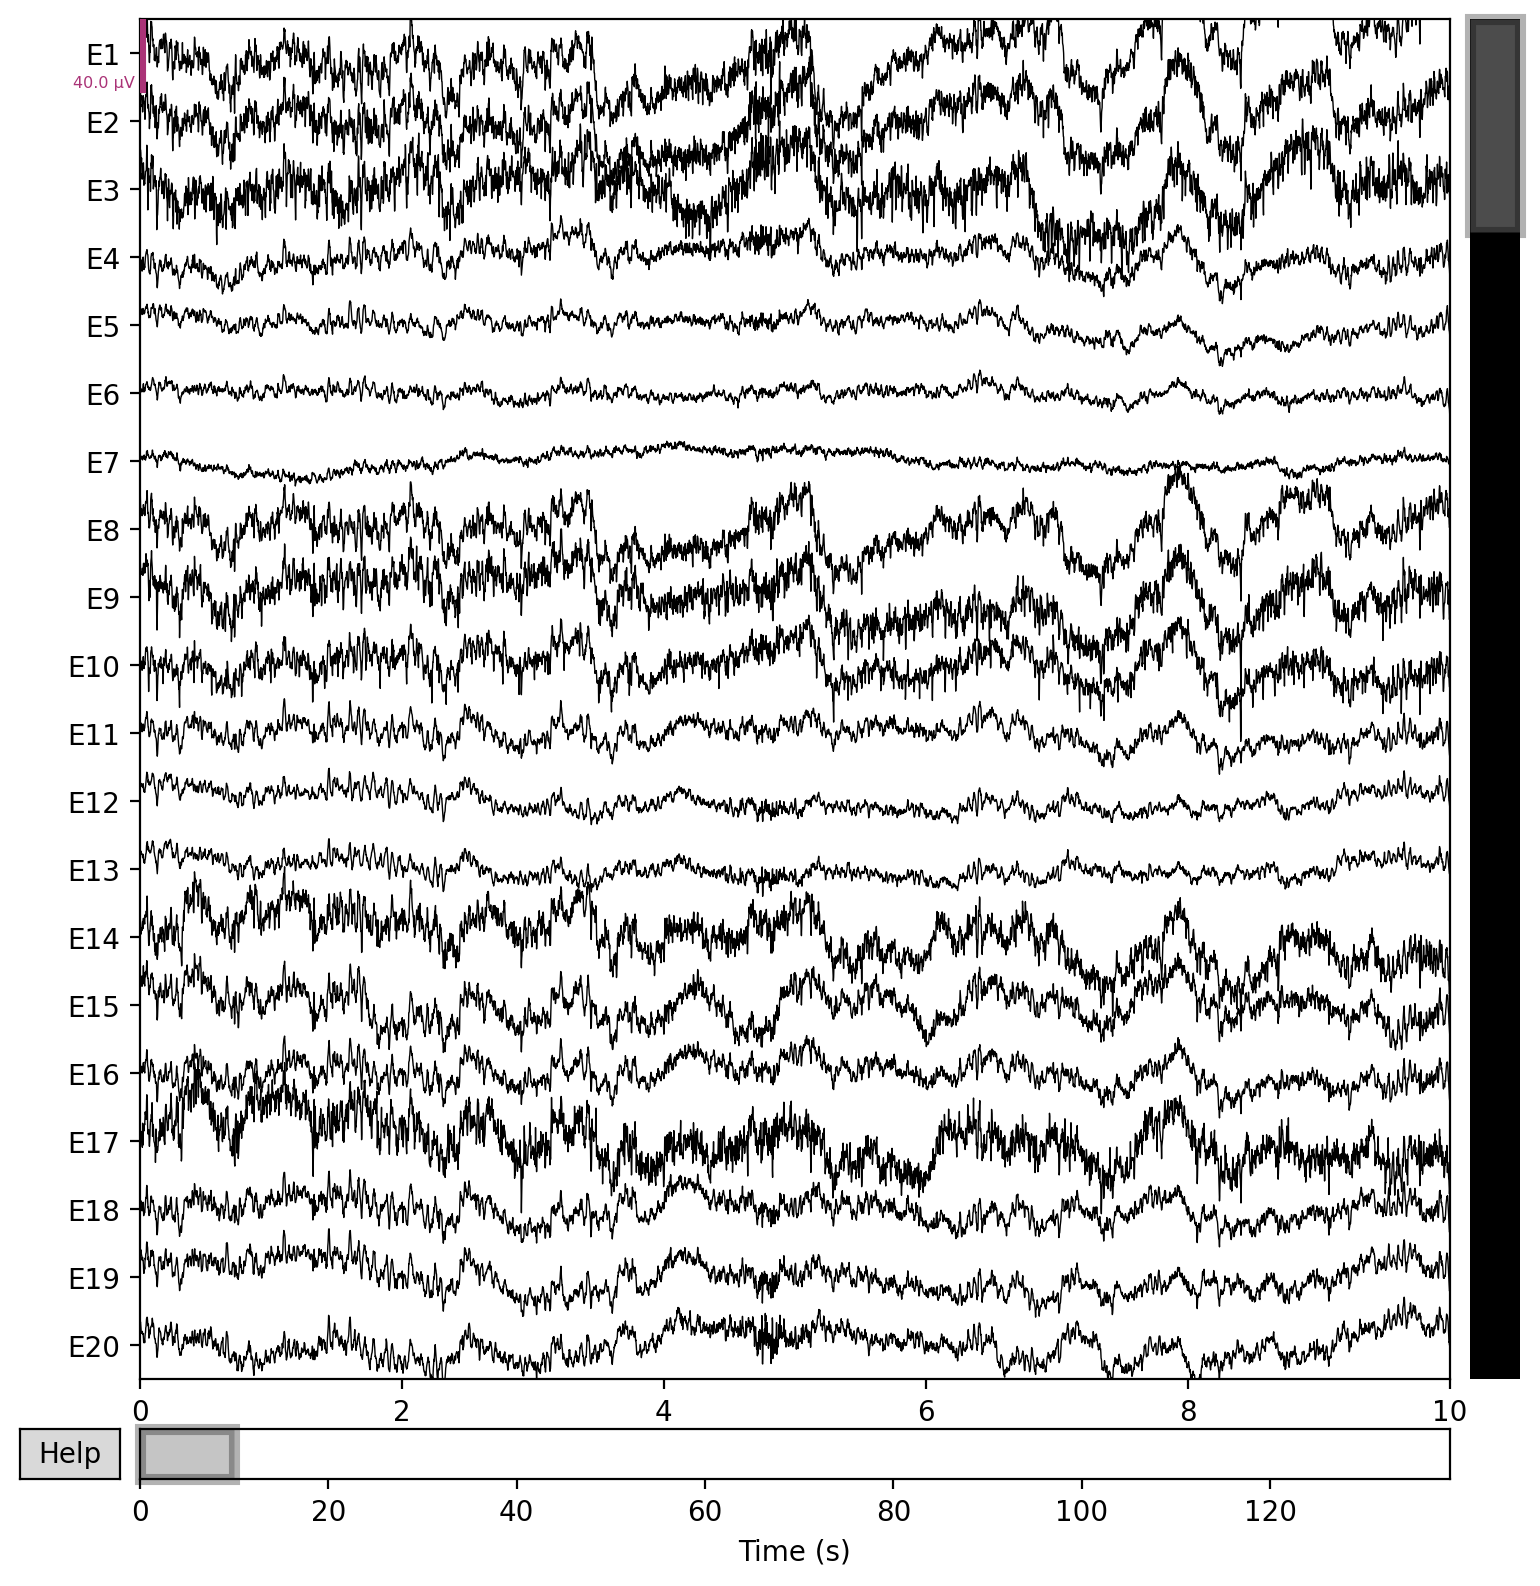

Channels marked as bad:
none


In [42]:
bad_filtered_zaplined_interpolated_raw.plot()

Creating RawArray with float64 data, n_channels=128, n_times=69554
    Range : 0 ... 69553 =      0.000 ...   139.106 secs
Ready.


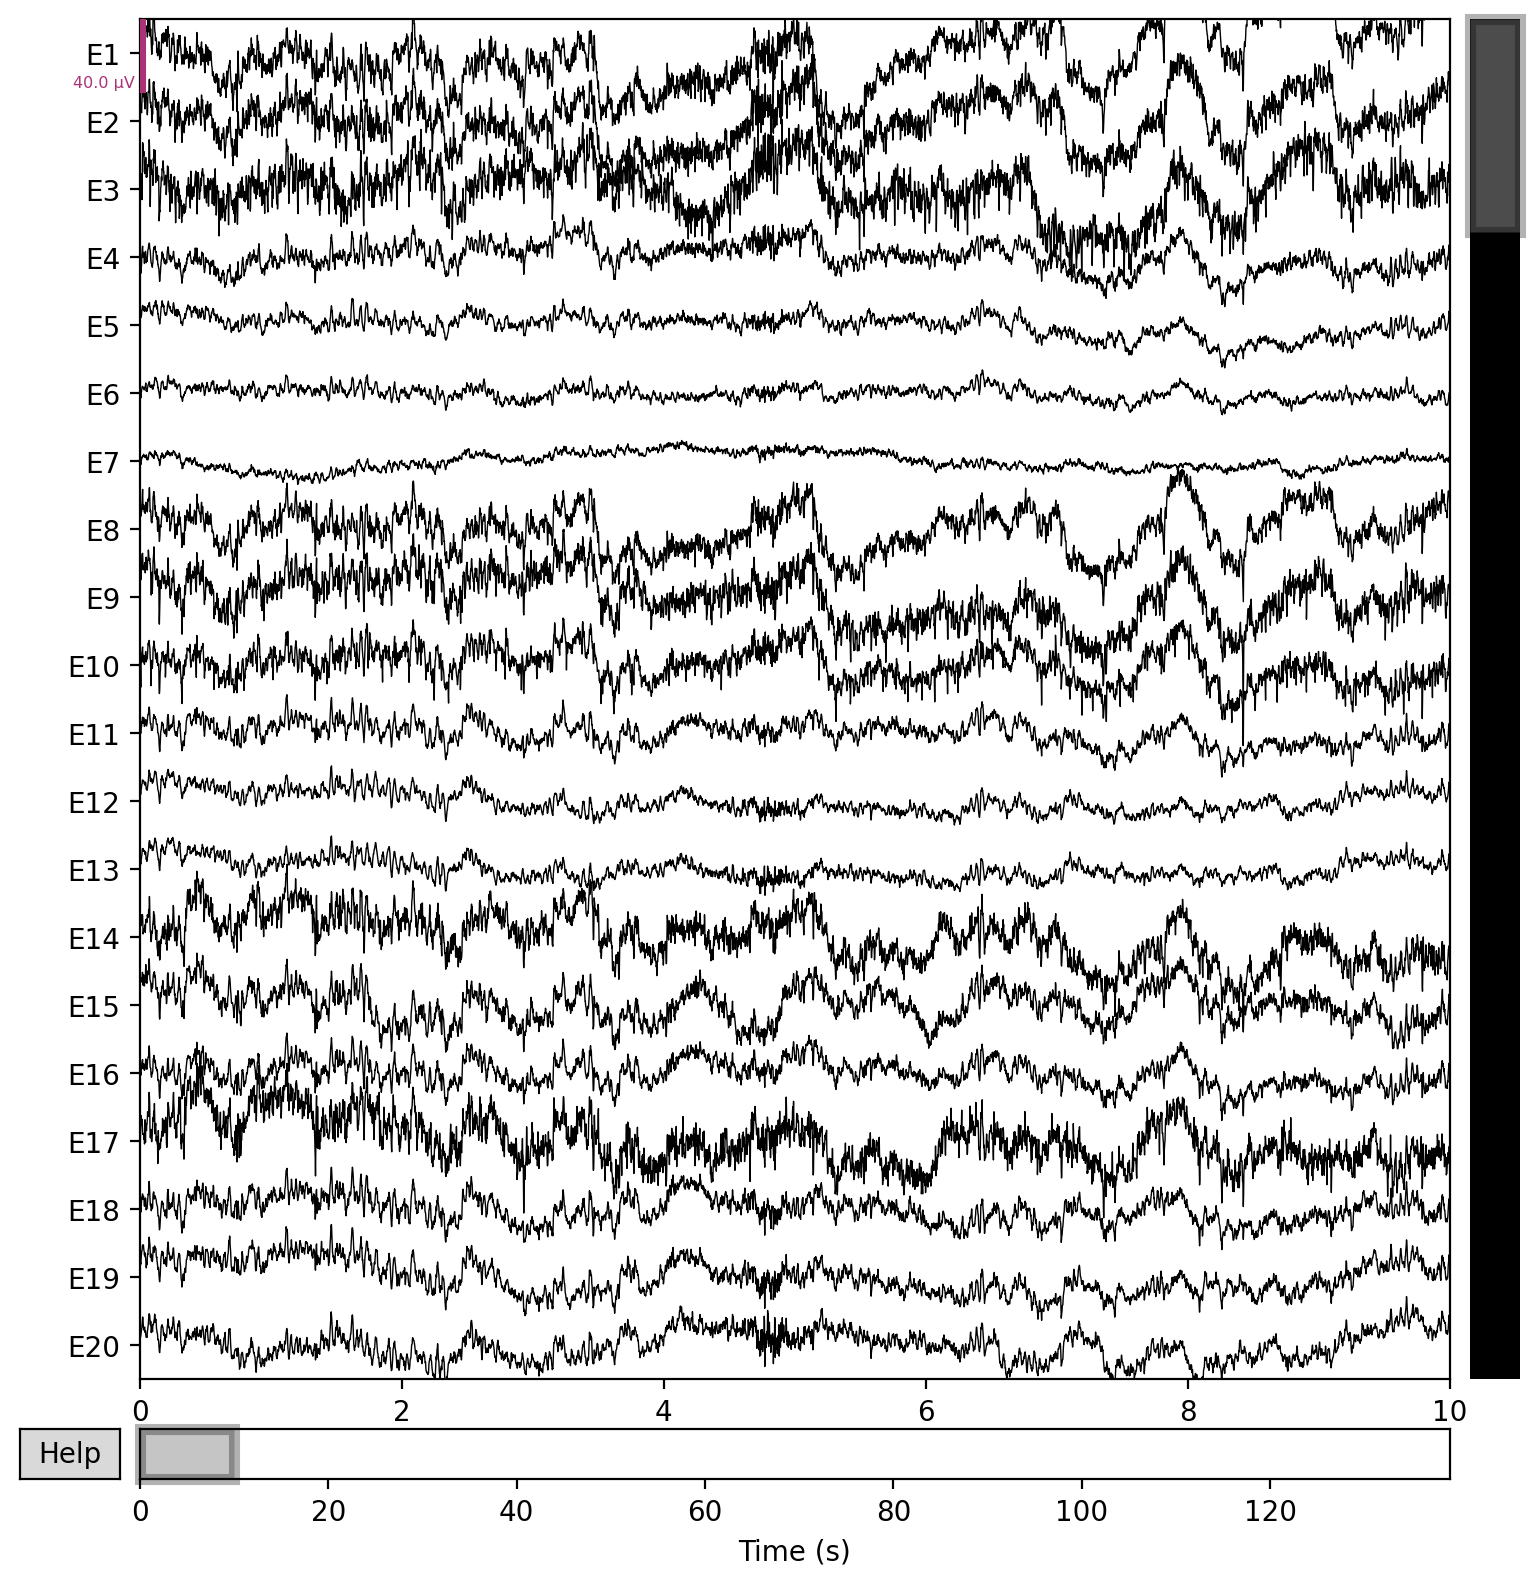

Channels marked as bad:
none
Channels marked as bad:
none


In [40]:
create_raw(matlab_filtered_zaplined_interpolated).plot()